### Librerie

In [1]:
import requests
import time
from datetime import datetime
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
from ratelimit import limits, RateLimitException, sleep_and_retry
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
from urllib.parse import urlparse
from urllib.parse import parse_qs
import re
import sys
import copy
import emoji
import functools
import seaborn as sns
import shutil

In [195]:
replace_emoji = lambda x: emoji.replace_emoji(x).strip()

In [4]:
ONE_SECOND = 1
TEN_SECONDS = 10
MAX_CALLS_PER_PERIOD = 0.9

### API

In [15]:
@sleep_and_retry
@limits(calls=MAX_CALLS_PER_PERIOD, period=ONE_SECOND)
def get_from_api(api,params,**kwargs):
    domain='https://www.tikwm.com/api/'
    res = requests.get(
    url=domain+api,
    params = params,
    **kwargs)
    try:
        if res.status_code==429: return (res,None)
        return (res, res.json()['data']) if res.json()['code'] == 0 else (res, None)
    except:
        print("log")
        with open("log.txt","a") as f:
            f.write(str(res.status_code))
            f.write(str(res.json()))
            f.write("")            
        return (None,None)

def get_video_info(url,**kwargs):
    return get_from_api('', params={"url": url,"web": 1, "hd": 1},**kwargs)

def get_user_info(unique_id,**kwargs):
    return get_from_api("user/info/", params={"unique_id": unique_id},**kwargs)

def get_user_similar(user,count=50,**kwargs):
    return get_from_api("user/discover/", params={"unique_id": user,"count":count},**kwargs)

def get_user_video(unique_id, cursor=0, count=35,**kwargs):
    return get_from_api("user/posts/", params={"unique_id": unique_id, "count": count, "cursor": cursor,"web": 1, "hd": 1},**kwargs)

def get_user_following(user_id, time=0, count=200, **kwargs):
    return get_from_api("user/following/", params={"user_id": user_id, "count": count, "time": time},**kwargs)

def get_user_followers(user_id, time=0,count=200,**kwargs):
    return get_from_api("user/followers/", params={"user_id": user_id, "count": count, "time": time},**kwargs)

def get_region(**kwargs):
    return get_from_api("region/", params={},**kwargs)

def get_comments(url, cursor=0,count=50, **kwargs):
    return get_from_api("comment/list/", params={"url": url, "count": count, "cursor": cursor},**kwargs)

def get_replies(comment_id, cursor=0,count=50, **kwargs):
    return get_from_api("comment/reply/", params={"comment_id": comment_id, "count": count, "cursor": cursor},**kwargs)

def get_favorite(user, cursor=0,count=35, **kwargs):
    return get_from_api("favorite/list/", params={"unique_id": user, "count": count, "cursor": cursor},**kwargs)

@sleep_and_retry
@limits(calls=1, period=10)
def get_video_by_keywords(keywords, cursor=0,count=30, **kwargs):
    return get_from_api("feed/search", params={"keywords": keywords, "count": count, "cursor": cursor,"web": 1, "hd": 1},**kwargs)

In [6]:
def get_params(url):
    return {key:value[0] for key,value in parse_qs(urlparse(url).query).items()}

### Profili

In [3]:
profili=["lilyebert","tovafriedman","thetrueadventures"]

### Inizializzazione dizionario / caricamento

In [ ]:
profili_analizzati={p:{"video":{}} for p in profili}

### Estrazioni informazioni profilo

In [ ]:
lista_pool=profili.copy()
lista_pool_tmp=[]
stampa=True
with PoolExecutor(max_workers=8) as executor:
    while len(lista_pool) > 0:
        for pool_value,(res,data) in zip(lista_pool,executor.map(get_user_info, lista_pool)):
            p=pool_value
            if data is None:
                lista_pool_tmp.append(p)
                if stampa: print(f"Waiting for API, {p = }")
                continue
            if stampa: print(f"Success {p = }")
            profili_analizzati[p]["info"]=data
        lista_pool=lista_pool_tmp.copy()
        lista_pool_tmp=[]

### Estrazione video profilo

In [ ]:
lista_pool=[[profilo,0] for profilo in profili]
lista_pool_tmp=[]
stampa=True
with PoolExecutor(max_workers=8) as executor:     
    while lista_pool:
        for pool_value,(res,data) in zip(lista_pool,executor.map(get_user_video, *zip(*lista_pool))):
            pbar.update(1)
            p=pool_value[0]
            cursor=pool_value[1]
            if data is None:
                lista_pool_tmp.append(pool_value)
                if stampa: print(f"Waiting for API, {p = }")
                continue
            if stampa: print(f"Success {p = } {cursor = }")
            for video in data['videos']:
                d_temp={}
                d_temp[video["video_id"]]=video
                d_temp[video["video_id"]].pop("video_id")
                profili_analizzati[p]["video"].update(d_temp)
            if data['hasMore']:
                lista_pool_tmp.append([p,data['cursor']])
        lista_pool=lista_pool_tmp.copy()
        lista_pool_tmp=[]

### Salvataggio dizionario info e video / caricamento

In [45]:
json.dump(profili_analizzati,open("profili_analizzati_info_video.json","w"),indent=4)

### Inizializzazione dizionario commenti / caricamento

In [158]:
dict_commenti={p:{video_id:{} for video_id in profili_analizzati[p]["video"].keys()} for p in profili}

In [ ]:
stampa=False 
for p in profili:
    with PoolExecutor(max_workers=8) as executor:   
        lista_pool=[[video_id,0] for video_id in dict_commenti[p].keys()]
        lista_pool_tmp=[] 
        while lista_pool:
            for pool_value,(res,data) in zip(lista_pool,executor.map(get_comments, *zip(*lista_pool))):
                video_id=pool_value[0]
                cursor=pool_value[1]
                if data is None:
                    lista_pool_tmp.append(pool_value)
                    if stampa: print(f"Waiting for API, {video_id = } {cursor = }")
                    continue
                if stampa: print(f"Success {p = } {cursor = }")
                for commento in data['comments']:
                    d_temp={}
                    d_temp[commento["id"]]=commento
                    d_temp[commento["id"]].pop("id")
                    dict_commenti[p][video_id].update(d_temp)
                if data['hasMore']:
                    lista_pool_tmp.append([video_id,data['cursor']])
            lista_pool=lista_pool_tmp.copy()
            lista_pool_tmp=[]

In [ ]:
json.dump(dict_commenti,open("dictCommenti.json","w"))

## Analisi per:
- like
- like normalizzato (/visualizzazioni)
- ratio (comment/like)

In [5]:
base_tiktok_video="https://www.tiktok.com/@{}/video/{}"

In [73]:
dfVideo=pd.DataFrame({
      "id":base_tiktok_video.format(p,key),
      "profile":p,
      "createTime":datetime.fromtimestamp(video["create_time"]),
      "playCount":video["play_count"],
      "likeCount":video["digg_count"],
      "likeCountNormalized":video["digg_count"]/video["play_count"],
      "commentCount":video["comment_count"],
      "music_id":video["music_info"]["id"] if "music_info" in video else None,
      "music_title":video["music_info"]["title"] if "music_info" in video else None,
      #"realCommentCount":len(dict_commenti[p][key]),
      #"replyCount":sum([commento["reply_total"] for id_commento,commento in dict_commenti[p][key].items()]),
      #"realReplyCommentCount":sum([len(d_r) for id_commento,d_r in dictRisposteMm[p][key].items()]) if key in b else 0,
      "commentCountNormalized":video["comment_count"]/video["play_count"],
      "shareCount":video["share_count"],
      "shareCountNormalized":video["share_count"]/video["play_count"],
      "downloadCount":video["download_count"],
      "downloadCountNormalized":video["download_count"]/video["play_count"],
      "ratio (comment/like)":video["comment_count"]/video["digg_count"],
      } for p in profili for key,video in profili_analizzati_completo[p]["video"].items()).set_index("id")

In [152]:
start_date = datetime(2021, 10, 1)
end_date = datetime(2022, 10, 1)

In [74]:
dfVideoRange=dfVideo[(dfVideo.createTime <= end_date) & (dfVideo.createTime >= start_date)]

In [52]:
lista_analisi2=set()

for p in profili:
    dfTmp=dfVideoRange[dfVideoRange.profile==p].copy().drop(columns=["profile"])
    
    lcM=dfTmp.sort_values(by="likeCount",ascending=False).head(10)
    lcM.to_html(f"{p}_likeCount2Ma.html")
    lista_analisi2.update(lcM.index.to_list())
    
    lcm=dfTmp.sort_values(by="likeCount",ascending=True).head(10)
    lcm.to_html(f"{p}_likeCount2mi.html")
    lista_analisi2.update(lcm.index.to_list())
    
    ccM=dfTmp.sort_values(by="commentCount",ascending=False).head(10)
    ccM.to_html(f"{p}_commentCount2Ma.html")
    lista_analisi2.update(ccM.index.to_list())
    
    ccm=dfTmp.sort_values(by="commentCount",ascending=True).head(10)
    ccm.to_html(f"{p}_commentCount2mi.html")
    lista_analisi2.update(ccm.index.to_list())

json.dump(list(lista_analisi2),open("lista_analisi.txt","w"))

In [10]:
listaVideoInteressanti_profilo_video=[(video.split("/")[-3][1:],video.split("/")[-1]) for video in listaVideoInteressanti_file]

### Risposte commenti

In [ ]:
a,b=zip(*listaVideoInteressanti_profilo_video)

In [236]:
dictRisposte={p:{id_v:{id_c:{} for id_c,info_c in d_comm.items()} for id_v,d_comm in d_video.items() if id_v in b}for p,d_video in dict_commenti.items()}

In [40]:
stampa=False
with PoolExecutor(max_workers=8) as executor:
    for p,id_v in listaVideoInteressanti_profilo_video:
        lista_pool=[[id_c,0] for id_c in dictRisposte[p][id_v].keys()]
        lista_pool_tmp=[] 
        while lista_pool:
            for pool_value,(res,data) in zip(lista_pool,executor.map(get_replies, *zip(*lista_pool))):
                id_c=pool_value[0]
                cursor=pool_value[1]
                if data is None:
                    lista_pool_tmp.append(pool_value)
                    if stampa: print(f"Waiting for API, {video_id = } {cursor = }")
                    continue
                if stampa: print(f"Success {p = } {cursor = }")
                for risposta in data['comments']:
                    d_temp={}
                    d_temp[risposta["id"]]=risposta
                    d_temp[risposta["id"]].pop("id")
                    dictRisposte[p][id_v][id_c].update(d_temp)
                if data['hasMore']:
                    lista_pool_tmp.append([id_c,data['cursor']])
            lista_pool=lista_pool_tmp.copy()
            lista_pool_tmp=[]

  0%|          | 0/84 [00:00<?, ?it/s]

In [401]:
json.dump(dictRisposte,open("dictRisposte.json","w"))

### Estrazione followers

In [94]:
list_followers={}
data="2022-12-27"

In [ ]:
stampa=False
for p in profili:
    list_followers_id=[follower["id"] for follower in list_followers[p]]
    time_api=None
    n_f=True
    user_id=profili_analizzati[p]["info"]["user"]["id"]
    while True:
        if time_api is None:
            res,foll=get_user_followers(user_id)
        else:
            res,foll=get_user_followers(user_id,time=time_api)
        time.sleep(1)
        if foll is None: 
            print(f"Waiting API, {len(list_followers_id):}")
            continue
        for f in foll["followers"]:
            if f["id"] not in list_followers_id:
                if n_f:
                    print("new follower")
                    n_f=False
                list_followers[p].append(f)
                list_followers_id.append(f["id"])
        if foll["hasMore"]:
            time_api=foll["time"]
        else:
            break

In [499]:
dictFollower={p:{} for p in profili}

In [500]:
idToP={profili_analizzati[p]["info"]["user"]["id"]:p for p in profili}

In [502]:
stampa=False
with PoolExecutor(max_workers=8) as executor:
    lista_pool=[[profili_analizzati[profilo]["info"]["user"]["id"],0] for profilo in profili]
    lista_pool_tmp=[] 
    while lista_pool:
        for pool_value,(res,data) in zip(lista_pool,executor.map(get_user_followers, *zip(*lista_pool))):
            profilo=pool_value[0]
            time=pool_value[1]
            if data is None:
                lista_pool_tmp.append(pool_value)
                if stampa: print(f"Waiting for API, {profilo = } {time = }")
                continue
            if stampa: print(f"Success {profilo = } {time = }")
            for follower in data['followers']:
                d_temp={}
                d_temp[follower["id"]]=follower
                d_temp[follower["id"]].pop("id")
                dictFollower[idToP[profilo]].update(d_temp)
            if data['hasMore']:
                lista_pool_tmp.append([profilo,data['time']])
        lista_pool=lista_pool_tmp.copy()
        lista_pool_tmp=[]

### Estrazione following

In [100]:
list_following={}
data="2022-11-08"

In [ ]:
stampa=False
for p in profili:
    try:
        list_following_id=[followed["id"] for followed in list_following[p]]
    except:
        list_following_id=[]
    time_api=None
    n_f=True
    user_id=profili_analizzati[p]["info"]["user"]["id"]
    while True:
        if time_api is None:
            res,foll=get_user_following(user_id)
        else:
            res,foll=get_user_following(user_id,time=time_api)
        time.sleep(1)
        if foll is None: 
            print(f"Waiting API, {len(list_following_id):}")
            continue
        for f in foll["followings"]:
            if f["id"] not in list_following_id:
                if n_f:
                    print("new follower")
                    n_f=False
                if p not in list_following:
                    list_following[p]=[]
                list_following[p].append(f)
                list_following_id.append(f["id"])
        if foll["hasMore"]:
            time_api=foll["time"]
        else:
            break

In [114]:
json.dump(list_following,open(f"following/{today()}/list_of_following.json", "w"))

### Estrazione suggeriti

In [20]:
similari={}

In [22]:
stampa=False
for p in profili:
    while True:
        res,similar=get_user_similar(p)
        time.sleep(10)
        if similar is None: 
            print(f"Waiting API, {p = }")
            continue
        similari[p]=similar
        break

In [30]:
new_folder(f"similari/{today()}")
json.dump(similari,open(f"similari/{today()}/similar.json", "w"))

In [37]:
for profilo,similar in similari.items():
    with open(f"similari/{today()}/{profilo}.txt","w") as f:
        for s in similar:
            f.write(s["user"]["uniqueId"])
            f.write("\n")

In [ ]:
simL=json.load(open("similari/lilyebert.json","r"))
simT=json.load(open("similari/tovafriedman.json","r"))
simTT=json.load(open("similari/thetrueadventures.json","r"))

## Analisi Sentiment

#### Rilevazione lingua

In [407]:
import fasttext
fasttext.FastText.eprint = lambda x: None
model = fasttext.load_model("../models/lid.176.bin")

In [408]:
detect_language_fasttext=lambda text: model.predict(text.replace("\n"," "))[0][0].replace("__label__","")

#### Divisione commenti inglese e non

In [ ]:
sentiment_en={}
sentiment_no_en={}
for profilo,d_video in dict_commenti.items():
    for id_video,d_commenti in d_video.items():
        for id_commento,commento in d_commenti.items():
            if commento["text"]:
                text_no_emoji=replace_emoji(commento["text"])
                if text_no_emoji and detect_language_fasttext(text_no_emoji)!="en":
                    if profilo not in sentiment_no_en:
                        sentiment_no_en[profilo]={}
                    if id_video not in sentiment_no_en[profilo]:
                        sentiment_no_en[profilo][id_video]={}
                    sentiment_no_en[profilo][id_video][id_commento]={
                        "text": commento["text"], 
                        "region": commento["user"]["region"]
                    }
                else:
                    if profilo not in sentiment_en:
                        sentiment_en[profilo]={}
                    if id_video not in sentiment_en[profilo]:
                        sentiment_en[profilo][id_video]={}
                    sentiment_en[profilo][id_video][id_commento]={
                        "text": commento["text"], 
                        "region": commento["user"]["region"]
                    }

In [429]:
json.dump(sentiment_en,open("commenti/commenti_en.json","w"))

json.dump(sentiment_no_en,open("commenti/commenti_no_en.json","w"))

#### Divisione risposte commenti inglese e non

In [ ]:
sentiment_en={}
sentiment_no_en={}
for profilo,d_video in dictRisposte.items():
    for id_video,d_commenti in d_video.items():
        for id_commento,d_risposte in d_commenti.items():
            for id_risposta,risposta in d_risposte.items(): 
                if risposta["text"]:
                    text_no_emoji=replace_emoji(risposta["text"])
                    if text_no_emoji and detect_language_fasttext(text_no_emoji)!="en":
                        if profilo not in sentiment_no_en:
                            sentiment_no_en[profilo]={}
                        if id_video not in sentiment_no_en[profilo]:
                            sentiment_no_en[profilo][id_video]={}
                        if id_commento not in sentiment_no_en[profilo][id_video]:
                            sentiment_no_en[profilo][id_video][id_commento]={}      
                        sentiment_no_en[profilo][id_video][id_commento][id_risposta]={
                            "text": risposta["text"], 
                            "region": risposta["user"]["region"]
                        }
                    else:
                        if profilo not in sentiment_en:
                            sentiment_en[profilo]={}
                        if id_video not in sentiment_en[profilo]:
                            sentiment_en[profilo][id_video]={}
                        if id_commento not in sentiment_en[profilo][id_video]:
                            sentiment_en[profilo][id_video][id_commento]={}      
                        sentiment_en[profilo][id_video][id_commento][id_risposta]={
                            "text": risposta["text"], 
                            "region": risposta["user"]["region"]
                        }

In [438]:
json.dump(sentiment_en,open("risposte/risposte_en.json","w"))

json.dump(sentiment_no_en,open("risposte/risposte_no_en.json","w"))

In [6]:
profili_analizzati_completo=json.load(open("principaleprofili/profili_analizzati_completo(sentiment_commenti_risposte_en).json","r"))

### Analisi dati

#### Dataframe
- idVideo
- idCommento
- sentiment vader

In [7]:
dfSentimentEmotionHateCommenti=pd.DataFrame([{
    "profiloVideo":profilo,
    "idVideo":base_tiktok_video.format(profilo,id_video),
    "dateVideo":datetime.fromtimestamp(video["create_time"]),
    "idCommento":id_commento,
    "dateCommento":datetime.fromtimestamp(commento["create_time"]),
    "profiloCommento":commento["user"]["unique_id"],
    "text":commento["text"],
    "sentiment_vader":commento["sentiment_vader"],
    "hate_speech":commento["hate_speech"]["classes"]["hate_speech"],
    "offensive_language":commento["hate_speech"]["classes"]["offensive_language"],
    "neither":commento["hate_speech"]["classes"]["neither"],
    "top_class_hate":commento["hate_speech"]["top_class"],
    "Happy":commento["emotion"]["Happy"],
    "Angry":commento["emotion"]["Angry"],
    "Surprise":commento["emotion"]["Surprise"],
    "Sad":commento["emotion"]["Sad"],
    "Fear":commento["emotion"]["Fear"],
    "top_class_emotion":list({k: v for k, v in sorted(commento["emotion"].items(), key=lambda item: item[1],reverse=True)}.items())[0],
} 
    for profilo,info_video in profili_analizzati_completo.items() 
    for id_video,video in info_video["video"].items()
    for id_commento,commento in video["comment"].items()
    if "sentiment_vader" in commento
]).set_index(["idVideo","idCommento"])

In [8]:
dfSentimentEmotionHateCommenti["top_class_emotion"]=dfSentimentEmotionHateCommenti["top_class_emotion"].apply(lambda x: x[0] if x[1] else None)

In [ ]:
t=dfSentimentEmotionHateCommenti[(dfSentimentEmotionHateCommenti.sentiment_vader<-0.8) & (dfSentimentEmotionHateCommenti.sentiment_vader>-2)].head(50)
t.style.set_properties(subset=['text'], **{'width': '300px'})

In [ ]:
dfSentimentEmotionHateCommenti.sort_values(by="neither",ascending=False).head(500).reset_index()[["text","hate_speech","offensive_language","neither","top_class_hate"]].style.set_properties(subset=['text'], **{'width': '300px'})

In [ ]:
dfSentimentEmotionHateCommenti.sort_values(by="Fear",ascending=False).head(50).style.set_properties(subset=['text'], **{'width': '300px'})

In [9]:
t=dfSentimentEmotionHateCommenti.groupby(["profiloVideo","top_class_hate"]).count()

In [10]:
t2=dfSentimentEmotionHateCommenti.groupby(["profiloVideo","top_class_emotion"]).count()

In [11]:
# Negative < -0.6
# Neutral_Negative -0.2 < x < -0.6
# Neutral -0.2 < x < 0.2
# Neutral_Positive 0.2 < x < 0.6
# Positive > 0.6
#dfSentimentEmotionHateCommenti["sentiment"]=dfSentimentEmotionHateCommenti["sentiment_vader"].apply(lambda x: "1Negative" if x<-0.6 else ("2Neutral_Negative" if x>=-0.6 and x<-0.2 else ("3Neutral" if x>=-0.2 and x<0.2 else ("4Neutral_Positive" if x>=0.2 and x<0.6 else "5Positive"))))
# Negative < -0.333
# Neutral -0.333 < x < 0.333
# Positive > 0.333
dfSentimentEmotionHateCommenti["sentiment"]=dfSentimentEmotionHateCommenti["sentiment_vader"].apply(lambda x: "1Negative" if x<-0.333 else ("2Neutral" if x>=-0.333 and x<0.333 else "3Positive"))

In [12]:
t3=dfSentimentEmotionHateCommenti.groupby(["profiloVideo","sentiment"]).count()

<AxesSubplot: xlabel='sentiment_vader', ylabel='Count'>

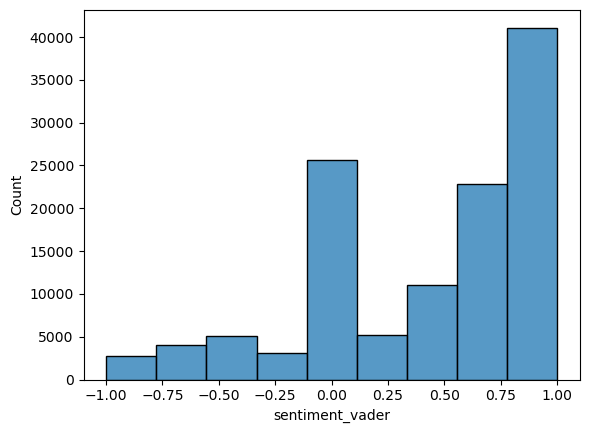

In [69]:
dfTemp=dfSentimentEmotionHateCommenti[dfSentimentEmotionHateCommenti.profiloVideo==profili[0]]
sns.histplot(data=dfTemp,x="sentiment_vader",bins=9)

thetrueadventures


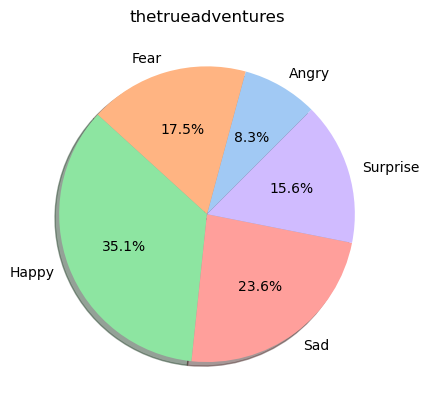

In [164]:
p=2
print(profili[p])
data = t2.loc[profili[p]].profiloCommento
#labels = [v[1:] for v in t3.loc[profili[p]].index]
labels = t2.loc[profili[p]].index

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:len(labels)]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%1.1f%%', startangle=45,shadow=True)
plt.title(profili[p])
plt.savefig("../../../../../../Desktop/Tesi/Immagini/emotion_"+profili[p]+".png",bbox_inches='tight')

In [19]:
from datetime import timedelta

In [30]:
dfCommenti=pd.DataFrame([{
    "profiloVideo":profilo,
    "idVideo":base_tiktok_video.format(profilo,id_video),
    "dateVideo":datetime.fromtimestamp(video["create_time"]),
    "idCommento":id_commento,
    "dateCommento":datetime.fromtimestamp(commento["create_time"]),
    "profiloCommento":commento["user"]["unique_id"],
    "text":commento["text"],
    "replyCount":len(commento["reply"]) if "reply" in commento else 0,
    "inglese": "sentiment_vader" in commento
} 
    for profilo,info_video in profili_analizzati_completo.items() 
    for id_video,video in info_video["video"].items()
    for id_commento,commento in video["comment"].items()
]).set_index(["idVideo","idCommento"])

In [34]:
range_date="01/10/2021 - 30/09/2022"

In [ ]:
for p in profili:
    print(p)
    dfTemp=dfCommenti[(dfCommenti.profiloVideo==p) & (dfCommenti.dateVideo<=end_date) & (dfCommenti.dateVideo>=start_date)]
    print(dfTemp.shape[0])
    dfTempInt=dfTemp[(dfTemp.index.get_level_values(0).isin(listaVideoInteressanti_file))]
    print(dfTempInt.shape[0])
    dfTempIntInglese=dfTempInt[(dfTempInt.inglese)]
    print(dfTempIntInglese.shape[0])

    dfTempCR=dfTemp[(dfTemp.dateCommento<=end_date) & (dfTemp.dateCommento>=start_date)]
    print(dfTempCR.shape[0])
    dfTempCRInt=dfTempCR[(dfTempCR.index.get_level_values(0).isin(listaVideoInteressanti_file))]
    print(dfTempCRInt.shape[0])
    dfTempCRIntInglese=dfTempCRInt[(dfTempCRInt.inglese)]
    print(dfTempCRIntInglese.shape[0])

In [68]:
dfCommenti[(dfCommenti.profiloCommento=="lilyebert") & (dfCommenti.text=="")].head(50)

profiloVideo  \
idVideo                                            idCommento                         
https://www.tiktok.com/@lilyebert/video/7175888... 7175971662792672005    lilyebert   
https://www.tiktok.com/@lilyebert/video/7174514... 7174835598166311685    lilyebert   
https://www.tiktok.com/@lilyebert/video/7174037... 7174791309730300677    lilyebert   
https://www.tiktok.com/@lilyebert/video/7173668... 7175861608055407366    lilyebert   
                                                   7175545363741819653    lilyebert   
                                                   7174692386512126725    lilyebert   
                                                   7174487877039309573    lilyebert   
                                                   7174042301210608390    lilyebert   
                                                   7173993186749776646    lilyebert   
https://www.tiktok.com/@lilyebert/video/7169244... 7169576129979384581    lilyebert   
https://www.tiktok.com/@lilyebert/video/7168572... 7168760668874179333    lilyebert   

                                                                       profiloCommento  \
idVideo                                            idCommento                            
https://www.tiktok.com/@lilyebert/video/7175888... 7175971662792672005       lilyebert   
https://www.tiktok.com/@lilyebert/video/7174514... 7174835598166311685       lilyebert   
https://www.tiktok.com/@lilyebert/video/7174037... 7174791309730300677       lilyebert   
https://www.tiktok.com/@lilyebert/video/7173668... 7175861608055407366       lilyebert   
                                                   7175545363741819653       lilyebert   
                                                   7174692386512126725       lilyebert   
                                                   7174487877039309573       lilyebert   
                                                   7174042301210608390       lilyebert   
                                                   7173993186749776646       lilyebert   
https://www.tiktok.com/@lilyebert/video/7169244... 7169576129979384581       lilyebert   
https://www.tiktok.com/@lilyebert/video/7168572... 7168760668874179333       lilyebert   

                                                                       text  \
idVideo                                            idCommento                 
https://www.tiktok.com/@lilyebert/video/7175888... 7175971662792672005        
https://www.tiktok.com/@lilyebert/video/7174514... 7174835598166311685        
https://www.tiktok.com/@lilyebert/video/7174037... 7174791309730300677        
https://www.tiktok.com/@lilyebert/video/7173668... 7175861608055407366        
                                                   7175545363741819653        
                                                   7174692386512126725        
                                                   7174487877039309573        
                                                   7174042301210608390        
                                                   7173993186749776646        
https://www.tiktok.com/@lilyebert/video/7169244... 7169576129979384581        
https://www.tiktok.com/@lilyebert/video/7168572... 7168760668874179333        

                                                                        replyCount  
idVideo                                            idCommento                       
https://www.tiktok.com/@lilyebert/video/7175888... 7175971662792672005           0  
https://www.tiktok.com/@lilyebert/video/7174514... 7174835598166311685           0  
https://www.tiktok.com/@lilyebert/video/7174037... 7174791309730300677           0  
https://www.tiktok.com/@lilyebert/video/7173668... 7175861608055407366           0  
                                                   7175545363741819653           0  
                                                   7174692386512126725           0  
                                                   717448787

In [53]:
dfRisposte=pd.DataFrame([{
    "profiloVideo":profilo,
    "videoTitle":video["title"],
    "idVideo":base_tiktok_video.format(profilo,id_video),
    "dateVideo":datetime.fromtimestamp(video["create_time"]),
    "idCommento":id_commento,
    "dateCommento":datetime.fromtimestamp(commento["create_time"]),
    "profiloCommento":commento["user"]["unique_id"],
    "testoCommento":commento["text"],
    "idRisposta":id_risposta,
    "dateRisposta":datetime.fromtimestamp(risposta["create_time"]),
    "profiloRisposta":risposta["user"]["unique_id"],
    "testoRisposta":risposta["text"],
    "inglese": "sentiment_vader" in risposta
} 
    for profilo,info_video in profili_analizzati_completo.items() 
    for id_video,video in info_video["video"].items()
    for id_commento,commento in video["comment"].items()
    if "reply" in commento
    for id_risposta,risposta in commento["reply"].items()
]).set_index(["idVideo","idCommento"])

In [ ]:
for p in profili:
    print(p)
    dfTemp=dfRisposte[(dfRisposte.profiloVideo==p) & (dfRisposte.dateVideo<=end_date) & (dfRisposte.dateVideo>=start_date)]
    print(dfTemp.shape[0])
    dfTempInt=dfTemp[(dfTemp.index.get_level_values(0).isin(listaVideoInteressanti_file))]
    print(dfTempInt.shape[0])
    dfTempIntInglese=dfTempInt[(dfTempInt.inglese)]
    print(dfTempIntInglese.shape[0])

    dfTempCR=dfTemp[(dfTemp.dateCommento<=end_date) & (dfTemp.dateCommento>=start_date) & (dfTemp.dateRisposta<=end_date) & (dfTemp.dateRisposta>=start_date)]
    print(dfTempCR.shape[0])
    dfTempCRInt=dfTempCR[(dfTempCR.index.get_level_values(0).isin(listaVideoInteressanti_file))]
    print(dfTempCRInt.shape[0])
    dfTempCRIntInglese=dfTempCRInt[(dfTempCRInt.inglese)]
    print(dfTempCRIntInglese.shape[0])

In [136]:
dfTemp=pd.DataFrame([{
        "id":"@lilyebert",
        "followers":1915426,
        "video":30,
        "comment":67447,
        "reply":8674},{
        "id":"@tovafriedman",
        "followers":480554,
        "video":25,
        "comment":17414,
        "reply":9151},{
        "id":"@thetrueadventures",
        "followers":413618,
        "video":29,
        "comment":30769,
        "reply":11817}])

In [141]:
dfTemp2=pd.DataFrame([
    {"Profilo":"@lilyebert","followers":1915426,"video":30,"tipo":"Commenti","numero":67447,"auto":29},
    {"Profilo":"@lilyebert","followers":1915426,"video":30,"tipo":"Risposte","numero":8674,"auto":24},
    {"Profilo":"@tovafriedman","followers":480554,"video":25,"tipo":"Commenti","numero":17414,"auto":180},
    {"Profilo":"@tovafriedman","followers":480554,"video":25,"tipo":"Risposte","numero":9151,"auto":206},
    {"Profilo":"@thetrueadventures","followers":413618,"video":29,"tipo":"Commenti","numero":30769,"auto":184},
    {"Profilo":"@thetrueadventures","followers":413618,"video":29,"tipo":"Risposte","numero":11817,"auto":292}
])

In [142]:
dfTemp["comm_norm"]=(dfTemp["comment"]/dfTemp["video"])/dfTemp["followers"]
dfTemp["reply_norm"]=(dfTemp["reply"]/dfTemp["video"])/dfTemp["followers"]
dfTemp["reply_comm_norm"]=dfTemp["reply"]/dfTemp["comment"]
dfTemp2["norm"]=(dfTemp2["numero"]/dfTemp2["video"])/dfTemp2["followers"]

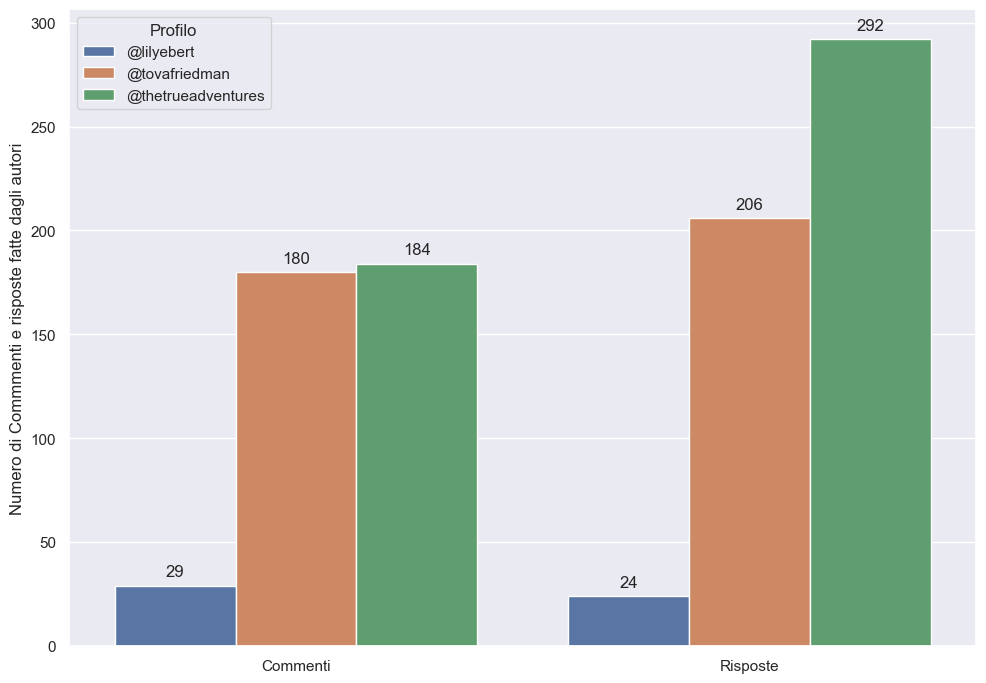

In [145]:
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="tipo", y="auto", hue="Profilo", data=dfTemp2)
ax.set_xlabel("")
ax.set_ylabel("Numero di Commmenti e risposte fatte dagli autori")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

array([11.7 ,  8.27])

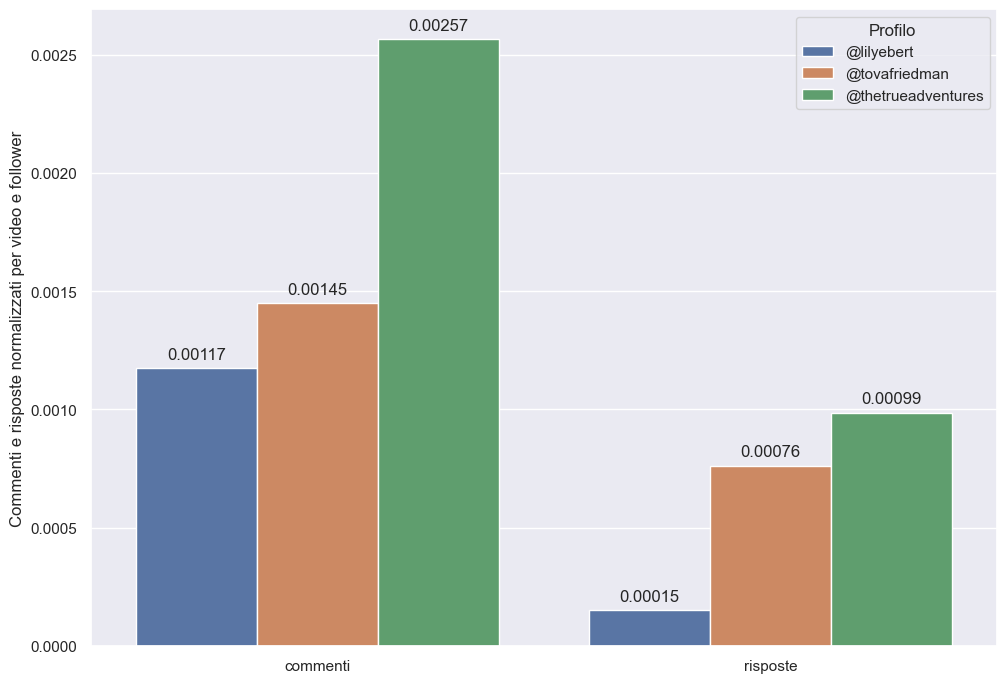

In [135]:
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="tipo", y="norm", hue="id", data=dfTemp2)
ax.set_xlabel("")
ax.set_ylabel("Commenti e risposte normalizzati per video e follower")
ax.legend(title="Profilo")
for p in ax.patches:
    ax.annotate(format(p.get_height(),".5f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.gcf().get_size_inches()

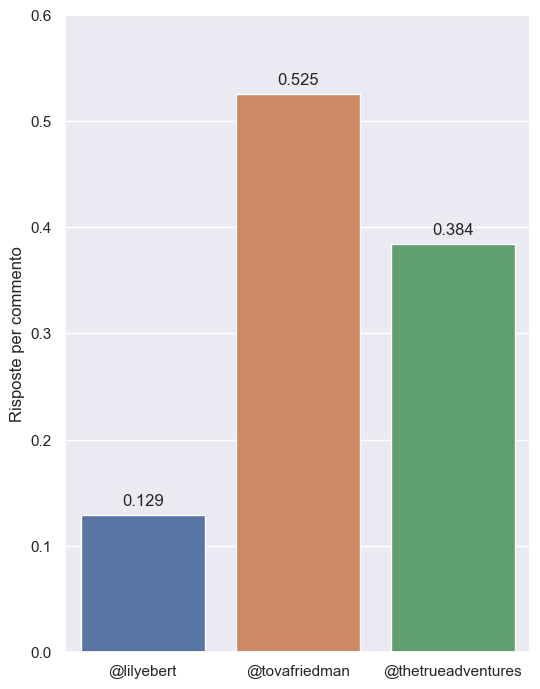

In [148]:
sns.set_theme(style="darkgrid")
ax=sns.barplot(data=dfTemp,x="id",y="reply_comm_norm")
ax.set_xlabel("")
ax.set_ylabel("Risposte per commento")
ax.set_ylim(0,0.6)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.gcf().set_size_inches(6, 8.27)

In [ ]:
for p in profili:
    print(p)
    print(dfVideo[(dfVideo.profile==p)].shape[0])
    print(dfVideo[(dfVideo.profile==p) & (dfVideo.index.isin(listaVideoInteressanti_file))].shape[0])

In [ ]:
for p in profili:
    print(p)
    print(dfVideoRange[(dfVideoRange.profile==p)].shape[0])
    print(dfVideoRange[(dfVideoRange.profile==p) & (dfVideoRange.index.isin(listaVideoInteressanti_file))].shape[0])

In [126]:
dfRisposte.groupby(["idVideo","idCommento"])[["idRisposta"]].count().sort_values("idRisposta",ascending=False).head(5)

idRisposta
idVideo                                            idCommento                     
https://www.tiktok.com/@tovafriedman/video/7018... 7018958418874598150        1066
https://www.tiktok.com/@thetrueadventures/video... 7048713059959194370         576
                                                   7048663912900182831         522
https://www.tiktok.com/@tovafriedman/video/7018... 7018954444646023942         446
https://www.tiktok.com/@tovafriedman/video/7052... 7052679590656901935         407

In [130]:
dfRisposte.loc["https://www.tiktok.com/@thetrueadventures/video/7048662758740512002","7048713059959194370"].reset_index()[["videoTitle","profiloCommento","testoCommento","idRisposta","profiloRisposta","testoRisposta"]]
## numero di risposte di un certo profilo, ordinati per numero di risposte
# .groupby("profiloRisposta").count().sort_values("idRisposta",ascending=False).head(50)
## commenti ordinati per numero di risposte
# .groupby(["idVideo","idCommento",""]).count().sort_values("idRisposta",ascending=False).head(50)

,profiloVideo,videoTitle,profiloCommento,testoCommento,idRisposta,testoRisposta
profiloRisposta,,,,,,
cathylove4all,316,316,316,316,316,316
thetrueadventures,293,293,293,293,293,293
annewern,229,229,229,229,229,229
tovafriedman,206,206,206,206,206,206
arsynist,197,197,197,197,197,197
gelashe57,194,194,194,194,194,194
simchatora,168,168,168,168,168,168
elian_alano_javier,164,164,164,164,164,164
speedogomer,164,164,164,164,164,164


### per ogni video i profili che hanno commentato ordinati per numero di commenti

In [18]:
a=dfCommenti[(dfCommenti.profiloVideo != dfCommenti.profiloCommento) & (dfCommenti.index.get_level_values(0).isin(listaVideoInteressanti_file))]\
.groupby(["idVideo","profiloCommento"])\
.count()[["profiloVideo"]]\
.sort_values(["profiloVideo"],ascending=False)\
.groupby(level=0,group_keys=False)\
.apply(lambda x: x.sort_values(["profiloVideo"],ascending=False))
a[a.profiloVideo>1]\
#.apply(lambda x: x.sort_values(["profiloVideo"],ascending=False).head(5))

profiloVideo
idVideo                                            profiloCommento                  
https://www.tiktok.com/@lilyebert/video/7020789... eviecolx                        2
                                                   isabelladoxie                   2
                                                   preciouslife18                  2
https://www.tiktok.com/@lilyebert/video/7021214... consistentlysimping             4
                                                   maxim.schreiner                 4
...                                                                              ...
https://www.tiktok.com/@tovafriedman/video/7142... erinrenee_38                    2
                                                   faces4truth                     2
                                                   its_hannah20260                 2
                                                   historygeekz                    2
                                                   amyrose.spams                   2

[2410 rows x 1 columns]

In [125]:
a=dfCommenti[(dfCommenti.profiloCommento=="ninafreda") & (dfCommenti.profiloVideo=="lilyebert")]\
.reset_index()\
.set_index(["idVideo","profiloCommento"])
a[~a.index.duplicated(keep='first')].shape

(350, 4)

In [127]:
a=dfCommenti[dfCommenti.profiloVideo != dfCommenti.profiloCommento]\
.reset_index()\
.set_index(["profiloCommento","idVideo","profiloVideo"])
a[~a.index.duplicated(keep='first')]\
.reset_index()\
.set_index(["profiloCommento","profiloVideo"])\
.groupby(["profiloVideo","profiloCommento"])\
.count()[["idVideo"]]\
.sort_values(["idVideo"],ascending=False)\
.groupby(level=0,group_keys=False)\
.apply(lambda x: x.sort_values(["idVideo"],ascending=False).head(5))\
.to_excel("commenti/top5UtentiCheCommentanoPiùSpesso.xlsx")
# .count()[["idVideo"]]\
# .sort_values(["idVideo"],ascending=False)\

In [351]:
dfRisposte[(dfRisposte.profiloVideo==dfRisposte.profiloRisposta) & (dfRisposte.index.get_level_values(0).isin(listaVideoInteressanti_file))]\
[["profiloRisposta"]]\
.groupby("idVideo")\
.count()\
.sort_values(by="profiloRisposta",ascending=False)\
.to_excel("commenti/autocommenti(risposte)_2.xlsx")

In [353]:
dfCommenti[(dfCommenti.profiloVideo==dfCommenti.profiloCommento) & (dfCommenti.index.get_level_values(0).isin(listaVideoInteressanti_file))]\
[["profiloCommento"]]\
.groupby("idVideo")\
.count()\
.sort_values(by="profiloCommento",ascending=False)\
.to_excel("commenti/autocommenti(commenti)_2.xlsx")

### Per ogni video il commento con più risposte e risposte al commento

In [95]:
#commenti ordinati per numero di risposte
# a=dfCommenti[(dfCommenti.profiloVideo != dfCommenti.profiloCommento) & (dfCommenti.index.get_level_values(0).isin(listaVideoInteressanti_file))]\
# .groupby(["idVideo","profiloCommento"])\
# .count()[["profiloVideo"]]\
# .sort_values(["profiloVideo"],ascending=False)\
# .groupby(level=0,group_keys=False)\
# .apply(lambda x: x.sort_values(["profiloVideo"],ascending=False))
# a[a.profiloVideo>1]\
#     .to_excel("commenti/CommentiUtentiEsterniMaggioreDi1.xlsx")
#.apply(lambda x: x.sort_values(["profiloVideo"],ascending=False).head(5))

#dfCommenti.sort_values(by="replyCount",ascending=False).head()

indici=dfCommenti[dfCommenti.index.get_level_values(0).isin(listaVideoInteressanti_file)][["replyCount"]].sort_values(by="replyCount",ascending=False)\
.groupby(level=0,group_keys=False)\
.apply(lambda x: x.sort_values(by="replyCount",ascending=False).head(1))\
.sort_values(by="replyCount",ascending=False)\
.index.get_level_values(1)[:10]
dfRisposte[dfRisposte.index.get_level_values(1).isin(indici)]\
.to_excel("commenti/CommentiConPiùRisposte_top10.xlsx")

#### Istogramma sentiment vader

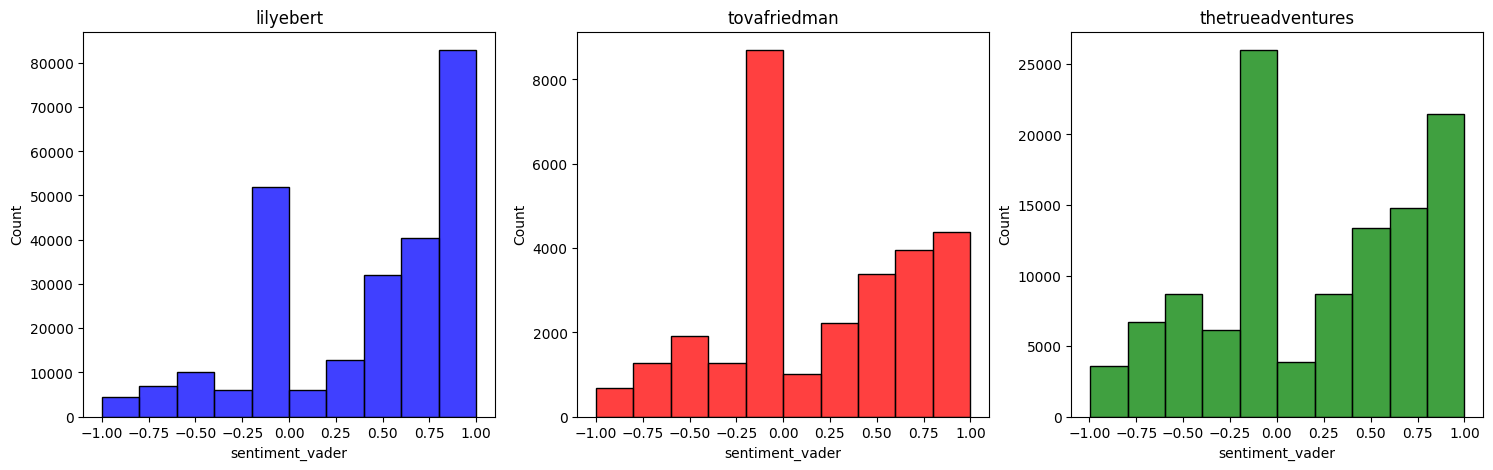

In [320]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(16, 5))
bins=10
sns.histplot(data=dfSentimentEmotionHateCommenti[dfSentimentEmotionHateCommenti.profilo==profili[0]], x="sentiment_vader", color="blue", ax=ax0,bins=bins).set(title=profili[0])
sns.histplot(data=dfSentimentEmotionHateCommenti[dfSentimentEmotionHateCommenti.profilo==profili[1]], x="sentiment_vader", color="red", ax=ax1,bins=bins).set(title=profili[1])
sns.histplot(data=dfSentimentEmotionHateCommenti[dfSentimentEmotionHateCommenti.profilo==profili[2]], x="sentiment_vader", color="green", ax=ax2,bins=bins).set(title=profili[2])

plt.subplots_adjust(right=1)
plt.show()

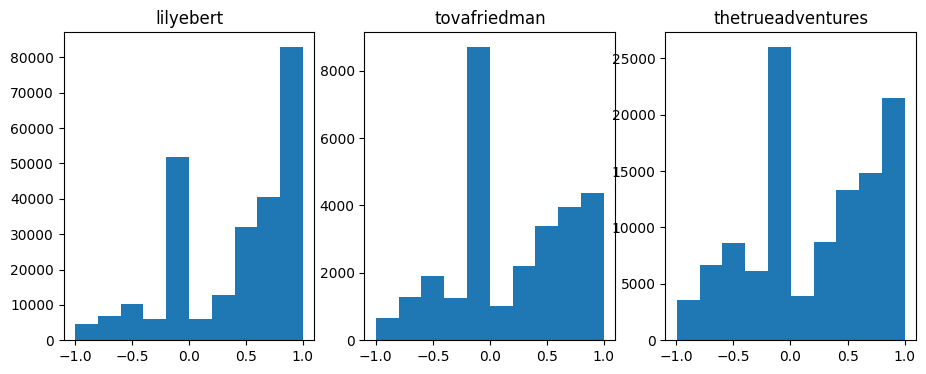

In [212]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.hist(dfSentimentEmotionHateCommenti[dfSentimentEmotionHateCommenti.profilo==profili[0]]["sentiment_vader"].to_list())
ax0.set_title(profili[0])
ax1.hist(dfSentimentEmotionHateCommenti[dfSentimentEmotionHateCommenti.profilo==profili[1]]["sentiment_vader"].to_list())
ax1.set_title(profili[1])
ax2.hist(dfSentimentEmotionHateCommenti[dfSentimentEmotionHateCommenti.profilo==profili[2]]["sentiment_vader"].to_list())
ax2.set_title(profili[2])
fig.set_figwidth(11)
fig.set_figheight(4)
plt.show()

#### Top 10 video commenti negativi

In [268]:
profilo=profili[1]
print(profilo)

tovafriedman


In [269]:
dfSentimentEmotionHateCommenti[
    (dfSentimentEmotionHateCommenti.profilo==profilo) &
    (dfSentimentEmotionHateCommenti.sentiment_vader<0)][["sentiment_vader"]]\
.groupby("idVideo")\
.count()\
.sort_values(by="sentiment_vader",ascending=False)\
.head(10)

,sentiment_vader
idVideo,
https://www.tiktok.com/@tovafriedman/video/7018874882096155910,1265
https://www.tiktok.com/@tovafriedman/video/7087063156253609259,366
https://www.tiktok.com/@tovafriedman/video/7016829421168446725,312
https://www.tiktok.com/@tovafriedman/video/7060509012156206383,310
https://www.tiktok.com/@tovafriedman/video/7168710755293072686,259
https://www.tiktok.com/@tovafriedman/video/7017074934778252549,214
https://www.tiktok.com/@tovafriedman/video/7060132477469494574,194
https://www.tiktok.com/@tovafriedman/video/7017902795378412806,166
https://www.tiktok.com/@tovafriedman/video/7035081399539354926,162


#### Top 10 video con la media più bassa di sentiment vader

In [270]:
dfSentimentEmotionHateCommenti[dfSentimentEmotionHateCommenti.profilo==profilo][["sentiment_vader"]]\
.groupby("idVideo")\
.mean()\
.sort_values(by="sentiment_vader",ascending=True)\
.head(10)

,sentiment_vader
idVideo,
https://www.tiktok.com/@tovafriedman/video/7129494007176236334,-0.066754
https://www.tiktok.com/@tovafriedman/video/7176233790052764971,-0.062927
https://www.tiktok.com/@tovafriedman/video/7016020587835346182,-0.034398
https://www.tiktok.com/@tovafriedman/video/7168710755293072686,-0.026514
https://www.tiktok.com/@tovafriedman/video/7172795392868764970,-0.006655
https://www.tiktok.com/@tovafriedman/video/7013034589564325125,-0.005163
https://www.tiktok.com/@tovafriedman/video/7060132477469494574,-0.004269
https://www.tiktok.com/@tovafriedman/video/7100259427957148970,0.004022
https://www.tiktok.com/@tovafriedman/video/7107838408457784618,0.015092


#### Top 10 video commenti negativi vader normalizzato

In [271]:
dfTmp=dfSentimentEmotionHateCommenti[
    (dfSentimentEmotionHateCommenti.profilo==profilo) &
    (dfSentimentEmotionHateCommenti.sentiment_vader<0)][["sentiment_vader"]]\
.groupby("idVideo")\
.count()
dfTmp["n_comments"]=[len(profili_analizzati_completo[profilo]["video"][index.split("/")[-1]]["comment"]) for index in dfTmp.index]
dfTmp["norm"]=dfTmp["sentiment_vader"]/dfTmp["n_comments"]
dfTmp.sort_values(by="norm",ascending=False)\
.head(10)

,sentiment_vader,n_comments,norm
idVideo,,,
https://www.tiktok.com/@tovafriedman/video/7013034589564325125,28,68,0.411765
https://www.tiktok.com/@tovafriedman/video/7176233790052764971,19,47,0.404255
https://www.tiktok.com/@tovafriedman/video/7060132477469494574,194,483,0.401656
https://www.tiktok.com/@tovafriedman/video/7172795392868764970,36,95,0.378947
https://www.tiktok.com/@tovafriedman/video/7129494007176236334,32,85,0.376471
https://www.tiktok.com/@tovafriedman/video/7016020587835346182,41,109,0.376147
https://www.tiktok.com/@tovafriedman/video/7010979339655187717,20,54,0.370370
https://www.tiktok.com/@tovafriedman/video/7029003162937724206,58,159,0.364780
https://www.tiktok.com/@tovafriedman/video/7107838408457784618,45,128,0.351562


#### Numero di autocommenti per video

In [12]:
dfC_L=pd.DataFrame([{
    "idVideo":base_tiktok_video.format(profili[0],id_video),
    "idCommento":commento["id"],
    "testo":commento["text"],
    "user":commento["user"]["unique_id"]
} for id_video,commenti in tmp.items() for commento in commenti]).set_index(["idVideo","idCommento"])

In [29]:
dfC_L.loc[dfC_L["user"]=="lilyebert"].groupby("idVideo").count().sort_values(by="testo",ascending=False)[["user"]].head()

,user
idVideo,
https://www.tiktok.com/@lilyebert/video/6927309816129965317,2
https://www.tiktok.com/@lilyebert/video/6929227126507851014,2
https://www.tiktok.com/@lilyebert/video/6934313818508119301,2
https://www.tiktok.com/@lilyebert/video/7042665974759296262,1
https://www.tiktok.com/@lilyebert/video/6974470084517465349,1


### Unione info profilo, video, commenti, risposte e sentiment

In [443]:
profili_analizzati_completo=copy.deepcopy(profili_analizzati)

In [439]:
dictCommenti=json.load(open("Commenti/2022-12-16/commenti.json","r"))
dictCommentiEn=json.load(open("Commenti/2022-12-16/Inglese/sentimentCommentiEn.json"))
dictRisposte=json.load(open("Risposte/2022-12-16/risposte.json","r"))
dictRisposteEn=json.load(open("Risposte/2022-12-16/Inglese/sentimentRisposteEn.json"))

In [440]:
dictCommentiRisposte=copy.deepcopy(dictCommenti)

In [441]:
for profilo,d_video in dictCommentiRisposte.items():
    for id_video,d_commenti in d_video.items():
        for id_commento,commento in d_commenti.items():
            if profilo in dictCommentiEn and id_video in dictCommentiEn[profilo] and id_commento in dictCommentiEn[profilo][id_video]:
                commento["sentiment_vader"]=dictCommentiEn[profilo][id_video][id_commento]["sentiment_vader"]
                hs_tmp=copy.deepcopy(dictCommentiEn[profilo][id_video][id_commento]["hate_speech"])
                commento["hate_speech"]={"top_class":hs_tmp["top_class"],"classes":{classes["class_name"]:classes["confidence"] for classes in hs_tmp["classes"]}}
                commento["emotion"]=dictCommentiEn[profilo][id_video][id_commento]["emotion"]
            
            if profilo in dictRisposte and id_video in dictRisposte[profilo] and id_commento in dictRisposte[profilo][id_video] and dictRisposte[profilo][id_video][id_commento]:
                commento["reply"]=copy.deepcopy(dictRisposte[profilo][id_video][id_commento])
                for id_risposta,risposta in commento["reply"].items():
                    if profilo in dictRisposteEn and id_video in dictRisposteEn[profilo] and id_commento in dictRisposteEn[profilo][id_video] and id_risposta in dictRisposteEn[profilo][id_video][id_commento]:
                        risposta["sentiment_vader"]=dictRisposteEn[profilo][id_video][id_commento][id_risposta]["sentiment_vader"]
                        hs_tmp2=copy.deepcopy(dictRisposteEn[profilo][id_video][id_commento][id_risposta]["hate_speech"])
                        risposta["hate_speech"]={"top_class":hs_tmp2["top_class"],"classes":{classes["class_name"]:classes["confidence"] for classes in hs_tmp2["classes"]}}
                        risposta["emotion"]=dictRisposteEn[profilo][id_video][id_commento][id_risposta]["emotion"]

In [442]:
json.dump(dictCommentiRisposte,open("commentiRisposte.json","w"))

In [444]:
for profilo,info_video in profili_analizzati_completo.items():
    for id_video,video in info_video["video"].items():
        video["comment"]=dictCommentiRisposte[profilo][id_video]

In [445]:
json.dump(profili_analizzati_completo,open("profili_analizzati_completo(sentiment_commenti_risposte_en).json","w"))

### Controllo numero commenti,risposte commenti

In [446]:
dfLength=pd.DataFrame({
      "idVideo":base_tiktok_video.format(profilo,id_video),
      "profilo":profilo,
      "commentCount":video["comment_count"],
      "realCommentCount":len(video["comment"]),
      "replyCount":sum([c["reply_total"] for id_c,c in video["comment"].items()]),
      "realReplyCommentCount":sum([len(c["reply"]) for id_c,c in video["comment"].items() if "reply" in c])
      } 
    for profilo,info_video in profili_analizzati_completo.items()
    for id_video,video in info_video["video"].items()
).set_index("idVideo")

In [447]:
dfLength["totale"]=dfLength["realCommentCount"]+dfLength["realReplyCommentCount"]

In [448]:
dfLength["perc"]=dfLength["totale"]/dfLength["commentCount"]

In [454]:
dfLength.filter(items=listaVideoInteressanti_file,axis=0).sort_values(by="commentCount",ascending=False).to_excel("out2.xlsx")

In [61]:
for cartella in ["ocr","ocr2","ocr3","ocr4"]:
    for profilo_t,video_t in listaVideoInteressanti_profilo_video:
        shutil.copyfile(f"video/{profilo_t}/{cartella}/{video_t}.txt",f"video/{profilo_t}/{cartella}/estratti/{video_t}.txt")

In [7]:
from neo4j import GraphDatabase
import json

In [8]:
uri=""
user=""
password=""
driver = GraphDatabase.driver(uri, auth=(user, password))

In [9]:
def deleteAll():
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")
    driver.close()

In [10]:
deleteAll()

In [11]:
def creaProfiloPrincipale(tx, id, uniqueId, nickname, signature, followingCount, followerCount, heartCount, videoCount):
    tx.run("""
    MERGE (user:User 
    {id: $id, 
    uniqueId: $uniqueId, 
    nickname: $nickname, 
    signature: $signature, 
    followingCount: $followingCount, 
    followerCount: $followerCount, 
    heartCount: $heartCount, 
    videoCount: $videoCount})""",
    id=id, uniqueId=uniqueId, nickname=nickname, signature=signature, followingCount=followingCount, followerCount=followerCount, heartCount=heartCount, videoCount=videoCount)

In [12]:
with driver.session() as session:
    for profilo,info in profili_analizzati_completo.items():
        tmp=info["info"]["user"]
        tmp2=info["info"]["stats"]
        session.execute_write(creaProfiloPrincipale, id=tmp["id"], uniqueId=tmp["uniqueId"], nickname=tmp["nickname"], signature=tmp["signature"], followingCount=tmp2["followingCount"], followerCount=tmp2["followerCount"], heartCount=tmp2["heartCount"], videoCount=tmp2["videoCount"])
driver.close()

In [13]:
def creaVideo(tx, id, profilo, region, title, duration, music_id, music_title, music_author, play_count, digg_count, comment_count, share_count, download_count, create_time):
    tx.run("""
    MATCH (user:User)
    WHERE user.uniqueId = $profilo
    MERGE (musica:Music {id: $music_id, title: $music_title, author: $music_author})
    MERGE (video:Video {id: $id, region: $region, title: $title, duration: $duration, play_count: $play_count, digg_count: $digg_count, comment_count: $comment_count, share_count: $share_count, download_count: $download_count, create_time: $create_time})
    MERGE (video)-[:HAS_MUSIC]->(musica)
    MERGE (user)-[:HAS_VIDEO]->(video)
    """,id=id, profilo=profilo, region=region, title=title, duration=duration, music_id=music_id, music_title=music_title, music_author=music_author, play_count=play_count, digg_count=digg_count, comment_count=comment_count, share_count=share_count, download_count=download_count, create_time=create_time)

In [14]:
with driver.session() as session:
    for profilo,dict_profilo in profili_analizzati_completo.items():
        for id_video,dict_video in dict_profilo["video"].items():
            session.execute_write(creaVideo, id=id_video, profilo=profilo, region=dict_video["region"], title=dict_video["title"], duration=dict_video["duration"], music_id=dict_video["music_info"]["id"], music_title=dict_video["music_info"]["title"], music_author=dict_video["music_info"]["author"], play_count=dict_video["play_count"], digg_count=dict_video["digg_count"], comment_count=dict_video["comment_count"], share_count=dict_video["share_count"], download_count=dict_video["download_count"], create_time=dict_video["create_time"])
driver.close()

In [16]:
# text
# create_time
# digg_count
# reply_total
# user id region unique_id nickname signature aweme_count follower_count                  favoriting_count                        total_favorited
#      id,       uniqueId  nickname signature             followerCount  followingCount,                   heartCount, videoCount
# sentiment_vader
# hate_speech hate_speech offensive_language neither
# emotion Happy Angry Surprise Sad Fear
def creaCommento(tx, id, video_id, text, create_time, digg_count, reply_total, user_id, user_region, user_unique_id, user_nickname, user_signature, user_aweme_count, user_follower_count, user_favoriting_count, user_total_favorited, sentiment_vader, hate_speech, offensive_language, neither, happy, angry, surprise, sad, fear):
    tx.run(
    """
    MATCH (video:Video)
    WHERE video.id = $video_id
    MERGE (commento:Comment {id: $id, text: $text, create_time: $create_time, digg_count: $digg_count, reply_total: $reply_total, sentiment_vader: $sentiment_vader, hate_speech: $hate_speech, offensive_language: $offensive_language, neither: $neither, happy: $happy, angry: $angry, surprise: $surprise, sad: $sad, fear: $fear})
    MERGE (utente:User {uniqueId: $user_unique_id})
    ON CREATE SET utente.id = $user_id, utente.region = $user_region, utente.nickname = $user_nickname, utente.signature = $user_signature, utente.awemeCount = $user_aweme_count, utente.followerCount = $user_follower_count, utente.favoritingCount = $user_favoriting_count, utente.totalFavorited = $user_total_favorited
    ON MATCH SET                        utente.region = $user_region,                                                                       utente.awemeCount = $user_aweme_count,                                              utente.favoritingCount = $user_favoriting_count, utente.totalFavorited = $user_total_favorited
    MERGE (commento)-[:HAS_AUTHOR]->(utente)
    MERGE (video)-[:HAS_COMMENT]->(commento)
    """, id=id, video_id=video_id, text=text, create_time=create_time, digg_count=digg_count, reply_total=reply_total, user_id=user_id, user_region=user_region, user_unique_id=user_unique_id, user_nickname=user_nickname, user_signature=user_signature, user_aweme_count=user_aweme_count, user_follower_count=user_follower_count, user_favoriting_count=user_favoriting_count, user_total_favorited=user_total_favorited, sentiment_vader=sentiment_vader, hate_speech=hate_speech, offensive_language=offensive_language, neither=neither, happy=happy, angry=angry, surprise=surprise, sad=sad, fear=fear)

In [17]:
with driver.session() as session:
    for profilo,dict_profilo in profili_analizzati_completo.items():
        tmp=dict_profilo["video"]
        for id_video,dict_video in tmp.items():
            tmp2=dict_video["comment"]
            for id_commento,dict_commento in tmp2.items():
                if "reply" in dict_commento.keys() and "sentiment_vader" in dict_commento.keys():
                    session.execute_write(creaCommento, id=id_commento, video_id=id_video, text=dict_commento["text"], create_time=dict_commento["create_time"], digg_count=dict_commento["digg_count"], reply_total=dict_commento["reply_total"], user_id=dict_commento["user"]["id"], user_region=dict_commento["user"]["region"], user_unique_id=dict_commento["user"]["unique_id"], user_nickname=dict_commento["user"]["nickname"], user_signature=dict_commento["user"]["signature"], user_aweme_count=dict_commento["user"]["aweme_count"], user_follower_count=dict_commento["user"]["follower_count"], user_favoriting_count=dict_commento["user"]["favoriting_count"], user_total_favorited=dict_commento["user"]["total_favorited"], sentiment_vader=dict_commento["sentiment_vader"], hate_speech=dict_commento["hate_speech"]["classes"]["hate_speech"], offensive_language=dict_commento["hate_speech"]["classes"]["offensive_language"], neither=dict_commento["hate_speech"]["classes"]["neither"], happy=dict_commento["emotion"]["Happy"], angry=dict_commento["emotion"]["Angry"], surprise=dict_commento["emotion"]["Surprise"], sad=dict_commento["emotion"]["Sad"], fear=dict_commento["emotion"]["Fear"])
driver.close()

In [18]:
# text
# create_time
# digg_count
# user, id region unique_id nickname signature aweme_count follower_count favoriting_count total_favorited
# sentiment_vader
# hate_speech, classes, hate_speech offensive_language neither
# emotion, Happy Angry Surprise Sad Fear

def creaRisposta(tx, id, commento_id, text, create_time, digg_count, user_id, user_region, user_unique_id, user_nickname, user_signature, user_aweme_count, user_follower_count, user_favoriting_count, user_total_favorited, sentiment_vader, hate_speech, offensive_language, neither, happy, angry, surprise, sad, fear):
    tx.run(
    """
    MATCH (commento:Comment)
    WHERE commento.id = $commento_id
    MERGE (risposta:Reply {id: $id, text: $text, create_time: $create_time, digg_count: $digg_count, sentiment_vader: $sentiment_vader, hate_speech: $hate_speech, offensive_language: $offensive_language, neither: $neither, happy: $happy, angry: $angry, surprise: $surprise, sad: $sad, fear: $fear})
    MERGE (utente:User {uniqueId: $user_unique_id})
    ON CREATE SET utente.id = $user_id, utente.region = $user_region, utente.nickname = $user_nickname, utente.signature = $user_signature, utente.awemeCount = $user_aweme_count, utente.followerCount = $user_follower_count, utente.favoritingCount = $user_favoriting_count, utente.totalFavorited = $user_total_favorited
    ON MATCH SET                        utente.region = $user_region,                                                                       utente.awemeCount = $user_aweme_count,                                              utente.favoritingCount = $user_favoriting_count, utente.totalFavorited = $user_total_favorited
    MERGE (risposta)-[:HAS_AUTHOR]->(utente)
    MERGE (commento)-[:HAS_REPLY]->(risposta)
    """, id=id, commento_id=commento_id, text=text, create_time=create_time, digg_count=digg_count, user_id=user_id, user_region=user_region, user_unique_id=user_unique_id, user_nickname=user_nickname, user_signature=user_signature, user_aweme_count=user_aweme_count, user_follower_count=user_follower_count, user_favoriting_count=user_favoriting_count, user_total_favorited=user_total_favorited, sentiment_vader=sentiment_vader, hate_speech=hate_speech, offensive_language=offensive_language, neither=neither, happy=happy, angry=angry, surprise=surprise, sad=sad, fear=fear)

In [19]:
with driver.session() as session:
    for profilo,dict_profilo in profili_analizzati_completo.items():
        tmp=dict_profilo["video"]
        for id_video,dict_video in tmp.items():
            tmp2=dict_video["comment"]
            for id_commento,dict_commento in tmp2.items():
                if "reply" in dict_commento.keys() and "sentiment_vader" in dict_commento.keys():
                    for id_risposta,dict_risposta in dict_commento["reply"].items():
                        if "sentiment_vader" in dict_risposta.keys():
                            session.execute_write(creaRisposta, id=id_risposta, commento_id=id_commento, text=dict_risposta["text"], create_time=dict_risposta["create_time"], digg_count=dict_risposta["digg_count"], user_id=dict_risposta["user"]["id"], user_region=dict_risposta["user"]["region"], user_unique_id=dict_risposta["user"]["unique_id"], user_nickname=dict_risposta["user"]["nickname"], user_signature=dict_risposta["user"]["signature"], user_aweme_count=dict_risposta["user"]["aweme_count"], user_follower_count=dict_risposta["user"]["follower_count"], user_favoriting_count=dict_risposta["user"]["favoriting_count"], user_total_favorited=dict_risposta["user"]["total_favorited"], sentiment_vader=dict_risposta["sentiment_vader"], hate_speech=dict_risposta["hate_speech"]["classes"]["hate_speech"], offensive_language=dict_risposta["hate_speech"]["classes"]["offensive_language"], neither=dict_risposta["hate_speech"]["classes"]["neither"], happy=dict_risposta["emotion"]["Happy"], angry=dict_risposta["emotion"]["Angry"], surprise=dict_risposta["emotion"]["Surprise"], sad=dict_risposta["emotion"]["Sad"], fear=dict_risposta["emotion"]["Fear"])
driver.close()

In [45]:
def creaEstrazioneOCR(tx, video_id, textOCR):
    tx.run(
    """
    MATCH (video:Video)
    WHERE video.id = $video_id
    MERGE (testoOCR:OCR {text: $textOCR})
    MERGE (video)-[:HAS_OCR]->(testoOCR)
    """,video_id=video_id, textOCR=textOCR)

In [46]:
def creaEstrazioneAudio(tx, video_id,textAudio):
    tx.run(
    """
    MATCH (video:Video)
    WHERE video.id = $video_id
    MERGE (testoAudio:Transcript {text: $textAudio})
    MERGE (video)-[:HAS_TRANSCRIPT]->(testoAudio)
    """,video_id=video_id, textAudio=textAudio)

In [48]:
for file in listaVideoInteressanti_file:
    video_id=file.split("/")[-1]
    profilo=file.split("/")[-3][1:]
    textOCR=json.load(open(f"../dati/video/{profilo}/ocr/estratti/{video_id}.txt", "r"))[0]
    textAudio=json.load(open(f"../dati/video/{profilo}/audio/testo/{video_id}.txt", "r"))
    with driver.session() as session:
        if textOCR: session.execute_write(creaEstrazioneOCR, video_id=video_id, textOCR=textOCR)
        if textAudio: session.execute_write(creaEstrazioneAudio, video_id=video_id, textAudio=textAudio)
driver.close()

In [190]:
profili_per_db={}
musiche_per_db={}
video_per_db={}
commenti_per_db={}
risposte_per_db={}

In [191]:
for profilo,dict_profilo in profili_analizzati_completo.items():
    profili_per_db[dict_profilo["info"]["user"]["id"]]={
        "id":dict_profilo["info"]["user"]["id"],
        "uniqueId":dict_profilo["info"]["user"]["uniqueId"],
        "nickname":dict_profilo["info"]["user"]["nickname"],
        "signature":dict_profilo["info"]["user"]["signature"],
        "followingCount":dict_profilo["info"]["stats"]["followingCount"],
        "followerCount":dict_profilo["info"]["stats"]["followerCount"],
        "heartCount":dict_profilo["info"]["stats"]["heartCount"],
        "videoCount":dict_profilo["info"]["stats"]["videoCount"],
        "diggCount":dict_profilo["info"]["stats"]["diggCount"]
    }
    tmp=dict_profilo["video"]
    for id_video,dict_video in tmp.items():
        video_per_db[id_video]={
            "id":id_video,
            "id_profilo":dict_profilo["info"]["user"]["id"],
            "id_music":dict_video["music_info"]["id"],
            "region":dict_video["region"],
            "title":dict_video["title"],
            "duration":dict_video["duration"],
            "play_count":dict_video["play_count"],
            "digg_count":dict_video["digg_count"],
            "comment_count":dict_video["comment_count"],
            "share_count":dict_video["share_count"],
            "download_count":dict_video["download_count"],
            "create_time":dict_video["create_time"]
        }
        if dict_video["music_info"]["id"] not in musiche_per_db.keys():
            musiche_per_db[dict_video["music_info"]["id"]]={
                "id":dict_video["music_info"]["id"],
                "title":dict_video["music_info"]["title"],
                "author":dict_video["music_info"]["author"]
            }
        tmp2=dict_video["comment"]
        for id_commento,dict_commento in tmp2.items():
            if "reply" in dict_commento.keys() and "sentiment_vader" in dict_commento.keys():
                commenti_per_db[id_commento]={
                    "id":id_commento,
                    "id_video":id_video,
                    "text":dict_commento["text"],
                    "create_time":dict_commento["create_time"],
                    "digg_count":dict_commento["digg_count"],
                    "user_id":dict_commento["user"]["id"],
                    "reply_total":dict_commento["reply_total"],
                    "sentiment_vader":dict_commento["sentiment_vader"],
                    "hate_speech":dict_commento["hate_speech"]["classes"]["hate_speech"],
                    "offensive_language":dict_commento["hate_speech"]["classes"]["offensive_language"],
                    "neither":dict_commento["hate_speech"]["classes"]["neither"],
                    "happy":dict_commento["emotion"]["Happy"],
                    "angry":dict_commento["emotion"]["Angry"],
                    "surprise":dict_commento["emotion"]["Surprise"],
                    "sad":dict_commento["emotion"]["Sad"],
                    "fear":dict_commento["emotion"]["Fear"]
                }
                if dict_commento["user"]["id"] not in profili_per_db.keys():
                    profili_per_db[dict_commento["user"]["id"]]={
                        "id":dict_commento["user"]["id"],
                        "region":dict_commento["user"]["region"],
                        "uniqueId":dict_commento["user"]["unique_id"],
                        "nickname":dict_commento["user"]["nickname"],
                        "signature":dict_commento["user"]["signature"],
                        "awemeCount":dict_commento["user"]["aweme_count"],
                        "followerCount":dict_commento["user"]["follower_count"],
                        "favoritingCount":dict_commento["user"]["favoriting_count"],
                        "totalFavorited":dict_commento["user"]["total_favorited"]
                    }
                else:
                    profili_per_db[dict_commento["user"]["id"]]["region"]=dict_commento["user"]["region"]
                    profili_per_db[dict_commento["user"]["id"]]["awemeCount"]=dict_commento["user"]["aweme_count"]
                    profili_per_db[dict_commento["user"]["id"]]["favoritingCount"]=dict_commento["user"]["favoriting_count"]
                    profili_per_db[dict_commento["user"]["id"]]["totalFavorited"]=dict_commento["user"]["total_favorited"]
                tmp3=dict_commento["reply"]
                for id_reply,dict_reply in tmp3.items():
                    if "sentiment_vader" in dict_reply.keys():
                        risposte_per_db[id_reply]={
                            "id":id_reply,
                            "id_commento":id_commento,
                            "text":dict_reply["text"],
                            "create_time":dict_reply["create_time"],
                            "digg_count":dict_reply["digg_count"],
                            "user_id":dict_reply["user"]["id"],
                            "sentiment_vader":dict_reply["sentiment_vader"],
                            "hate_speech":dict_reply["hate_speech"]["classes"]["hate_speech"],
                            "offensive_language":dict_reply["hate_speech"]["classes"]["offensive_language"],
                            "neither":dict_reply["hate_speech"]["classes"]["neither"],
                            "happy":dict_reply["emotion"]["Happy"],
                            "angry":dict_reply["emotion"]["Angry"],
                            "surprise":dict_reply["emotion"]["Surprise"],
                            "sad":dict_reply["emotion"]["Sad"],
                            "fear":dict_reply["emotion"]["Fear"]
                        }
                        if dict_reply["user"]["id"] not in profili_per_db.keys():
                            profili_per_db[dict_reply["user"]["id"]]={
                                "id":dict_reply["user"]["id"],
                                "region":dict_reply["user"]["region"],
                                "uniqueId":dict_reply["user"]["unique_id"],
                                "nickname":dict_reply["user"]["nickname"],
                                "signature":dict_reply["user"]["signature"],
                                "awemeCount":dict_reply["user"]["aweme_count"],
                                "followerCount":dict_reply["user"]["follower_count"],
                                "favoritingCount":dict_reply["user"]["favoriting_count"],
                                "totalFavorited":dict_reply["user"]["total_favorited"]
                            }
                        else:
                            profili_per_db[dict_reply["user"]["id"]]["region"]=dict_reply["user"]["region"]
                            profili_per_db[dict_reply["user"]["id"]]["awemeCount"]=dict_reply["user"]["aweme_count"]
                            profili_per_db[dict_reply["user"]["id"]]["favoritingCount"]=dict_reply["user"]["favoriting_count"]
                            profili_per_db[dict_reply["user"]["id"]]["totalFavorited"]=dict_reply["user"]["total_favorited"]

In [295]:
sql_utenti="""
CREATE TABLE `users` (
`id` bigint(20) NOT NULL,
`uniqueId` varchar(100) NOT NULL,
`region` varchar(100),
`nickname` varchar(100),
`signature` varchar(100),
`awemeCount` varchar(100),
`followerCount` bigint(20),
`followingCount` bigint(20),
`favoritingCount` bigint(20),
`totalFavorited` bigint(20),
`heartCount` bigint(20),
`videoCount` bigint(20), 
PRIMARY KEY (`id`))
"""

insert_utenti="""
INSERT INTO `users` (
    `id`, 
    `uniqueId`,
    `region`, 
    `nickname`, 
    `signature`, 
    `awemeCount`, 
    `followerCount`, 
    `followingCount`, 
    `favoritingCount`, 
    `totalFavorited`, 
    `heartCount`, 
    `videoCount`)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """
insert_utenti2="""
INSERT INTO `users` (
    `id`,
    `uniqueId`,
    `region`,
    `nickname`,
    `signature`,
    `awemeCount`,
    `followerCount`,
    `favoritingCount`,
    `totalFavorited`)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
    """

In [296]:
sql_video= """
CREATE TABLE `video` (
`id` bigint(20) NOT NULL, 
`id_profilo` bigint(20) NOT NULL, 
`id_music` bigint(20) NOT NULL, 
`region` varchar(100),
`title` varchar(100),
`duration` bigint(20),
`playCount` bigint(20),
`diggCount` bigint(20),
`commentCount` bigint(20),
`shareCount` bigint(20),
`downloadCount` bigint(20),
`createTime` bigint(20),
PRIMARY KEY (`id`))
"""
insert_video="""
INSERT INTO `video` (
    `id`,
    `id_profilo`,
    `id_music`,
    `region`,
    `title`,
    `duration`,
    `playCount`,
    `diggCount`,
    `commentCount`,
    `shareCount`,
    `downloadCount`,
    `createTime`)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """

In [324]:
sql_musiche="""
CREATE TABLE `musiche` (
`id` bigint(20) NOT NULL,
`title` varchar(100),
`author` varchar(100),
PRIMARY KEY (`id`))
"""
insert_musiche="""
INSERT INTO `musiche` (
    `id`,
    `title`,
    `author`)
    VALUES (%s, %s, %s)
    """


In [297]:
sql_commenti="""
CREATE TABLE `commenti` (
`id` bigint(20) NOT NULL,
`id_video` bigint(20) NOT NULL,
`user_id` bigint(20) NOT NULL,
`text` varchar(100),
`create_time` bigint(20),
`digg_count` bigint(20),
`reply_total` bigint(20),
`sentiment_vader` float(10),
`hate_speech` float(10),
`offensive_language` float(10),
`neither` float(10),
`happy` float(10),
`angry` float(10),
`surprise` float(10),
`sad` float(10),
`fear` float(10),
PRIMARY KEY (`id`))
"""
insert_commenti="""
INSERT INTO `commenti` (
    `id`,
    `id_video`,
    `user_id`,
    `text`,
    `create_time`,
    `digg_count`,
    `reply_total`,
    `sentiment_vader`,
    `hate_speech`,
    `offensive_language`,
    `neither`,
    `happy`,
    `angry`,
    `surprise`,
    `sad`,
    `fear`)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """

In [168]:
sql_region="""
CREATE TABLE `region` (
`id` varchar(100) NOT NULL,
`region` varchar(100),
PRIMARY KEY (`id`))
"""

insert_region="""
INSERT INTO `region` (
    `id`,
    `region`)
    VALUES (%s, %s)
    """

In [298]:
sql_risposte="""
CREATE TABLE `risposte` (
`id` bigint(20) NOT NULL,
`id_commento` bigint(20) NOT NULL,
`user_id` bigint(20) NOT NULL,
`text` varchar(100),
`create_time` bigint(20),
`digg_count` bigint(20),
`sentiment_vader` float(10),
`hate_speech` float(10),
`offensive_language` float(10),
`neither` float(10),
`happy` float(10),
`angry` float(10),
`surprise` float(10),
`sad` float(10),
`fear` float(10),
PRIMARY KEY (`id`))
"""

insert_risposte="""
INSERT INTO `risposte` (
    `id`,
    `id_commento`,
    `user_id`,
    `text`,
    `create_time`,
    `digg_count`,
    `sentiment_vader`,
    `hate_speech`,
    `offensive_language`,
    `neither`,
    `happy`,
    `angry`,
    `surprise`,
    `sad`,
    `fear`)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """

In [15]:
import pymysql.cursors
connection = pymysql.connect(host='',
                             user='',
                             password='',
                             database='',
                             cursorclass=pymysql.cursors.DictCursor)

In [326]:
connection.close()

In [318]:
with connection.cursor() as cursor:
        for _,value in list(profili_per_db.items()):
            if "followingCount" not in value.keys():
                cursor.execute(insert_utenti2, (value["id"],value["uniqueId"], value["region"], value["nickname"], value["signature"], value["awemeCount"], value["followerCount"], value["favoritingCount"], value["totalFavorited"]))
            else:
                cursor.execute(insert_utenti, (value["id"], value["uniqueId"], value["region"], value["nickname"], value["signature"], value["awemeCount"], value["followerCount"], value["followingCount"], value["favoritingCount"], value["totalFavorited"], value["heartCount"], value["videoCount"]))
        #cursor.execute(sql_risposte)
connection.commit()

In [ ]:
with connection.cursor() as cursor:
        for _,value in list(video_per_db.items()):
                cursor.execute(insert_video, (value["id"], value["id_profilo"], value["id_music"], value["region"], value["title"], value["duration"], value["play_count"], value["digg_count"], value["comment_count"], value["share_count"], value["download_count"], value["create_time"]))
connection.commit()

In [328]:
with connection.cursor() as cursor:
        for _,value in list(musiche_per_db.items()):
                cursor.execute(insert_musiche, (value["id"], value["title"], value["author"]))
connection.commit()

In [322]:
with connection.cursor() as cursor:
        for _,value in list(commenti_per_db.items()):
                cursor.execute(insert_commenti, (value["id"], value["id_video"], value["user_id"], value["text"], value["create_time"], value["digg_count"], value["reply_total"], value["sentiment_vader"], value["hate_speech"], value["offensive_language"], value["neither"], value["happy"], value["angry"], value["surprise"], value["sad"], value["fear"]))
connection.commit()

In [323]:
with connection.cursor() as cursor:
        for _,value in list(risposte_per_db.items()):
                cursor.execute(insert_risposte, (value["id"], value["id_commento"], value["user_id"], value["text"], value["create_time"], value["digg_count"], value["sentiment_vader"], value["hate_speech"], value["offensive_language"], value["neither"], value["happy"], value["angry"], value["surprise"], value["sad"], value["fear"]))
connection.commit()

In [171]:
with connection.cursor() as cursor:
        cursor.execute(sql_region)
        for code,region in data.items():
                cursor.execute(insert_region, (code, region))
connection.commit()